# Machine Learning Analysis for Ubiquant Competition

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import SMOTE
import numba as nb


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)

## Preprocessing data

In [234]:
stockname = 'UBIQ010'

path = 'dataset/1/'
df = pd.read_csv(path + f'{stockname}.csv')
start_datetime = datetime(2023, 1, 1)
df['DateTime'] = df['LocalTime'].apply(lambda x: start_datetime + timedelta(seconds=x))
df.set_index('DateTime', inplace=True)

for i in range(2,11):
    path = 'dataset/' + str(i) + '/'
    data = pd.read_csv(path + f'{stockname}.csv')
    start_datetime = datetime(2023, 1, i)
    data['DateTime'] = data['LocalTime'].apply(lambda x: start_datetime + timedelta(seconds=x))
    data.set_index('DateTime', inplace=True)
    df = pd.concat([df, data], axis=0)


file_list = os.listdir(path)
file_list = [file for file in file_list if file.endswith('.csv')]

In [235]:
df['MidPrice'] = (df['BidPrice1'] + df['AskPrice1']) / 2
df['W_Mid_Price'] = (df['BidPrice1'] * df['AskVolume1'] + df['AskPrice1'] * df['BidVolume1']) / (df['BidVolume1'] + df['AskVolume1'])
df['Volume'] = df['TradeVolume'].diff()
df.columns = [col if not col.endswith('A') else col[:-1] + '10' for col in df.columns]

In [236]:
df['return'] = df['MidPrice'].pct_change()
df['log_return'] = np.log(df['MidPrice'] / df['MidPrice'].shift(1))

<AxesSubplot:xlabel='DateTime'>

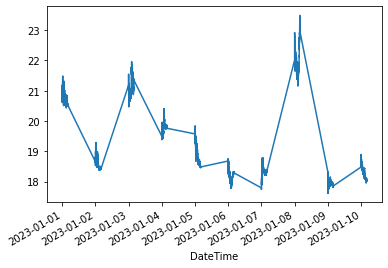

In [237]:
df['W_Mid_Price'].plot()

## Feature Engineering

In [238]:
# Spread-based features
df['price_vs_mid'] = np.log(df['LastPrice'] / df['MidPrice'])
df['spread'] = df['AskPrice1'] - df['BidPrice1']

In [239]:
# positive-ratio
window_size = 60
df['pos_trades'] = (df['LastPrice'] >= df['AskPrice1'].shift(1)).astype(int)
df['positive_ratio'] = df['pos_trades'].rolling(window_size).sum() / window_size

In [240]:
# Distance-based features
# df['ask_distance'] = df['AskPriceA'] - df['AskPrice1']
# df['bid_distance'] = df['BidPrice1'] - df['BidPriceA']
df['avg_distance_diff'] = (df['BidPrice1'] - df['BidPrice10']) - (df['AskPrice10'] - df['AskPrice1']) * 100

In [241]:
# Weighted average amount
df['w_bid_amt'] = sum(df[f'BidPrice{i}'] * df[f'BidVolume{i}'] * (1 - (i - 1) / 10) for i in range(1, 11))
df['w_ask_amt'] = sum(df[f'AskPrice{i}'] * df[f'AskVolume{i}'] * (1 - (i - 1) / 10) for i in range(1, 11))
df['amt_spread_tick'] = np.where((df['w_bid_amt'] + df['w_ask_amt']) > 0, 
                             (df['w_bid_amt'] - df['w_ask_amt']) / (df['w_bid_amt'] + df['w_ask_amt']), 
                             0)

df['w_bid_amt4'] = sum(df[f'BidPrice{i}'] * df[f'BidVolume{i}'] * (1 - (i - 1) / 4) for i in range(1, 5))
df['w_ask_amt4'] = sum(df[f'AskPrice{i}'] * df[f'AskVolume{i}'] * (1 - (i - 1) / 4) for i in range(1, 5))
df['amt_spread_tick4'] = np.where((df['w_bid_amt4'] + df['w_ask_amt4']) > 0, 
                             (df['w_bid_amt4'] - df['w_ask_amt4']) / (df['w_bid_amt4'] + df['w_ask_amt4']), 
                             0)

In [242]:
# Vwap and distance
df['tot_ask_amt'] = sum(df[f'AskPrice{i}'] * df[f'AskVolume{i}'] for i in range(1, 11))
df['tot_bid_amt'] = sum(df[f'BidPrice{i}'] * df[f'BidVolume{i}'] for i in range(1, 11))

# Vectorized total volumes
df['total_bid_vol'] = df[[f'BidVolume{i}' for i in range(1, 11)]].sum(axis=1)
df['total_ask_vol'] = df[[f'AskVolume{i}' for i in range(1, 11)]].sum(axis=1)

# VWAP calculations using direct division
df['ask_vwap'] = df['tot_ask_amt'] / df['total_ask_vol']
df['bid_vwap'] = df['tot_bid_amt'] / df['total_bid_vol']

# Distance from mid price with direct subtraction
df['ask_dist'] = df['ask_vwap'] - df['MidPrice']
df['bid_dist'] = df['MidPrice'] - df['bid_vwap']

In [243]:
# Extra Features
@nb.jit
def get_age(prices):
    last_value = prices[-1]
    age = 0
    for i in range(2, len(prices)):
        if prices[-i] != last_value:
            return age
        age += 1
    return age

window_size = 60

df['ask_age'] = df['AskPrice1'].rolling(window_size).apply(get_age, engine='numba', raw=True).fillna(0)
df['bid_age'] = df['BidPrice1'].rolling(window_size).apply(get_age, engine='numba', raw=True).fillna(0)

df['depth_price_range'] = (df['AskPrice1'].rolling(window_size).max() / df['AskPrice1'].rolling(window_size).min() - 1).fillna(0)


In [244]:
df['Bid_Volume_top4'] = df['BidVolume1'] + df['BidVolume2'] + df['BidVolume3'] + df['BidVolume4']
df['Ask_Volume_top4'] = df['AskVolume1'] + df['AskVolume2'] + df['AskVolume3'] + df['AskVolume4']
df['Vol_Imbalance'] = (df['Bid_Volume_top4'] - df['Ask_Volume_top4']) / (df['Bid_Volume_top4'] + df['Ask_Volume_top4'])

In [245]:
df['prev_bid_price'] = df['BidPrice1'].shift(1)
df['prev_bid_vol'] = df['BidVolume1'].shift(1)
df['prev_ask_price'] = df['AskPrice1'].shift(1)
df['prev_ask_vol'] = df['AskVolume1'].shift(1)

en_bid = np.where(df['BidPrice1'] == df['prev_bid_price'], 
                  df['BidVolume1'] - df['prev_bid_vol'], 
                  np.where(df['BidPrice1'] > df['prev_bid_price'], df['BidVolume1'], -df['prev_bid_vol']))

en_ask = np.where(df['AskPrice1'] == df['prev_ask_price'], 
                  -(df['AskVolume1'] - df['prev_ask_vol']), 
                  np.where(df['AskPrice1'] < df['prev_ask_price'], -df['AskVolume1'], df['prev_ask_vol']))

df['OFI'] = en_bid + en_ask

df.drop(['prev_bid_price', 'prev_bid_vol', 'prev_ask_price', 'prev_ask_vol'], axis=1, inplace=True)

In [246]:
window_size = 60
a = df['BidVolume1'] * np.where(df['BidPrice1'].diff() > 0, 1, 0)
b = df['BidVolume1'].shift() * np.where(df['BidPrice1'].diff() <= 0, 1, 0)
c = df['AskVolume1'] * np.where(df['AskPrice1'].diff() <= 0, 1, 0)
d = df['AskVolume1'].shift() * np.where(df['AskPrice1'].diff() >= 0, 1, 0)
df['cofi'] = (a - b - c + d).fillna(0)

In [247]:
df['bp_rank'] = (df['BidPrice1'].rolling(window_size).rank() / window_size * 2 - 1).fillna(0)
df['ap_rank'] = (df['AskPrice1'].rolling(window_size).rank() / window_size * 2 - 1).fillna(0)

In [248]:
n = 10
ask_w = sum(df[f'AskPrice{i}'] * df[f'AskVolume{i}'] for i in range(1, n+1))
bid_w = sum(df[f'BidPrice{i}'] * df[f'BidVolume{i}'] for i in range(1, n+1))
ask_v = sum(df[f'AskVolume{i}'] for i in range(1, n+1))
bid_v = sum(df[f'BidVolume{i}'] for i in range(1, n+1))
ask_w /= ask_v
bid_w /= bid_v
df['price_impact'] = -(df['AskPrice1'] - ask_w)/df['AskPrice1'] - (df['BidPrice1'] - bid_w)/df['BidPrice1']

In [249]:
n = 5
bid_prices = [f'BidPrice{i}' for i in range(1, n+1)]
ask_prices = [f'AskPrice{i}' for i in range(1, n+1)]
prices = bid_prices + ask_prices
df['depth_price_skew'] = df[prices].skew(axis=1)
df['depth_price_kurt'] = df[prices].kurt(axis=1)


In [250]:
window_size = 60
df['rolling_return'] = (df['MidPrice'].diff(window_size) / df['MidPrice']).fillna(0)

In [251]:
for date, group in df.groupby(df.index.normalize()):
    # Delete rows from the start of the day
    df = df.drop(group.index[:10])

    # Delete rows from the end of the day
    df = df.drop(group.index[-10:])


In [252]:
# pct_change = (df['MidPrice'].resample('3T').last().pct_change().shift(-1)).dropna()
# pct_change.hist(bins=20)
# avg_return = df['log_return'].resample('3T').mean().shift(-1).dropna()
# avg_return.hist(bins=20)

In [253]:
# # Resampled target variable

# def cumulative_return(window):
#     if len(window) < 2:
#         return np.nan
#     start_price = window.iloc[0]
#     cumulative_pct_change = (window - start_price) / start_price
#     return cumulative_pct_change.max(), cumulative_pct_change.min()

# # Resample the data into 3-minute windows and apply the cumulative return function
# cumulative_returns = df['MidPrice'].resample('T').apply(cumulative_return).dropna()

# # Create a DataFrame from the results
# windowed_returns = pd.DataFrame(cumulative_returns.tolist(), index=cumulative_returns.index, columns=['cum_max', 'cum_min'])

# # Determine the condition and assign 1 or -1
# result = (abs(windowed_returns['cum_max']) > abs(windowed_returns['cum_min'])).map(lambda x: 1 if x else -1).shift(-1).dropna()
# result.hist()

<AxesSubplot:>

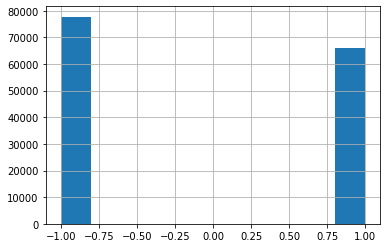

In [254]:
# Function to calculate maximum cumulative return for a window
def cumulative_return_max(window):
    if len(window) < 2:
        return np.nan
    start_price = window[0]
    cumulative_pct_change = (window - start_price) / start_price
    return cumulative_pct_change.max()

# Function to calculate minimum cumulative return for a window
def cumulative_return_min(window):
    if len(window) < 2:
        return np.nan
    start_price = window[0]
    cumulative_pct_change = (window - start_price) / start_price
    return cumulative_pct_change.min()

# Define the window size
window_size = 60  # Adjust this as needed

# Apply the cumulative return functions to a rolling window
cumulative_max = df['MidPrice'].rolling(window_size).apply(cumulative_return_max, raw=True).dropna()
cumulative_min = df['MidPrice'].rolling(window_size).apply(cumulative_return_min, raw=True).dropna()

# Create a DataFrame from the results
windowed_returns = pd.DataFrame({'cum_max': cumulative_max, 'cum_min': cumulative_min})

# Determine the condition and assign 1 or -1
result = (abs(windowed_returns['cum_max']) > abs(windowed_returns['cum_min'])).map(lambda x: 1 if x else -1).shift(-30).dropna()
result.hist()

<AxesSubplot:>

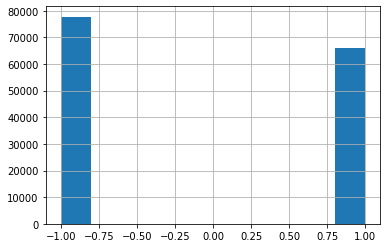

In [255]:
# Create a new target variable with values 1, 0, -1 based on the condition
# target = pd.Series(data=0, index=max_return.index)  # Initialize with 0
# target[avg_return > 0.0015] = 1  # Set to 1 where pct_change > 0.0015
# target[avg_return < -0.0015] = -1  # Set to -1 where pct_change < -0.0015
# target[max_return >= 0] = 1

# Plot the histogram
target = result
target.hist()

In [256]:
# aggregation_rules = {
#     col: 'mean' if 'BidPrice' in col or 'AskPrice' in col else 'sum'
#     for col in df.columns if 'BidPrice' in col or 'AskPrice' in col or 'BidVolume' in col or 'AskVolume' in col
# }

# additional_rules = {
#     'W_Mid_Price': 'mean',
#     'Volume': 'sum',
#     'log_return': 'sum',
#     'return': 'sum',
#     'lag3_ret': 'sum',
#     'lag5_ret': 'sum',
#     'lag10_ret': 'sum',
#     'price_vs_mid': 'mean',
#     'spread': 'mean',
#     'positive_ratio': 'mean',
#     'avg_distance_diff': 'mean',
#     'amt_spread_tick': 'mean',
#     'amt_spread_tick4': 'mean',
#     'ask_dist': 'mean',
#     'bid_dist': 'mean',
#     'ask_age': 'last',
#     'bid_age': 'last',
#     'depth_price_range': 'mean',
#     'Vol_Imbalance': 'mean',
#     'OFI': 'sum',
#     'cofi': 'sum',
#     'bp_rank': 'last',
#     'ap_rank': 'last',
#     'price_impact': 'mean',
#     'depth_price_skew': 'mean',
#     'depth_price_kurt': 'mean',
#     'rolling_return': 'last'
# }

# aggregation_rules.update(additional_rules)

# default_aggregation = {col: 'mean' for col in df.columns if col not in aggregation_rules}

# resampled_df = df.resample('1T').agg(aggregation_rules).dropna()

In [257]:
# resampled_df.head(243)

In [258]:
feature_selections = range(1, 11)
bid_price_features = [f'BidPrice{i}' for i in feature_selections]
bid_volume_features = [f'BidVolume{i}' for i in feature_selections]
ask_price_features = [f'AskPrice{i}' for i in feature_selections]
ask_volume_features = [f'AskVolume{i}' for i in feature_selections]

# feature_col = ['W_Mid_Price', 'Volume', 'lag3_ret', 'lag5_ret', 'lag10_ret', 'return', 'price_vs_mid', 'spread', 'positive_ratio', 'avg_distance_diff', 'amt_spread_tick', 'amt_spread_tick4', 'ask_dist', 'bid_dist']
feature_col = ['Volume', 'return', 'price_vs_mid', 'spread', 'positive_ratio', 'avg_distance_diff', 'amt_spread_tick', 'amt_spread_tick4', 'ask_dist', 'bid_dist', 'ask_age', 'bid_age', 'depth_price_range', 'Vol_Imbalance', 'OFI', 'bp_rank', 'ap_rank', 'price_impact', 'depth_price_skew', 'depth_price_kurt', 'rolling_return']


# feature_col = feature_col + bid_price_features + bid_volume_features + ask_price_features + ask_volume_features

features = df[feature_col]

In [259]:
# features.to_csv('temp_feature_016.csv')

In [260]:
X = features
y = target
X = X.loc[y.index]

In [261]:
def symize(series):
    res = pd.concat([series, -series])
    res.index = pd.DatetimeIndex([i for i in series.index] + [i for i in series.index])
    return res

In [262]:
# sym_X = pd.DataFrame()
# for col in X.columns:
#     sym_X[col] = symize(X[col])

# sym_X

In [263]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

In [264]:
from sklearn.model_selection import train_test_split

# Split the dataset into a training set (e.g., 80%) and a test set (e.g., 20%)
#X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now, X_train and y_train contain your training data, and X_test and y_test contain your test data.


X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# smote = SMOTE(random_state=42)
# X_train_val, y_train_val = smote.fit_resample(X_train_val, y_train_val)

# from tslearn.over_sampling import TimeSeriesSMOTE

# # Instantiate the TimeSeriesSMOTE class
# ts_smote = TimeSeriesSMOTE()

# # Apply TS SMOTE to balance the dataset
# X_train_val, y_train_val = ts_smote.fit_resample(X_train_val, y_train_val)

# Now, X_resampled and y_resampled contain the balanced time series dataset



In [265]:
import joblib

# Define models and their respective hyperparameter grids
model_params = {
    'LightGBM': {
        'model': lgb.LGBMClassifier(verbose=-1),
        'param_grid': {
            'model__n_estimators': [50, 100, 150, 200],
            'model__learning_rate': [0.001, 0.01, 0.03, 0.05],
            'model__class_weight': [{-1: 4.5, 1: 5.5}]
        }
    },
    # 'RandomForest': {
    #     'model': RandomForestClassifier(),
    #     'param_grid': {
    #         'model__n_estimators': [100, 200, 500, 1000],
    #         'model__max_depth': [10, 20, 30]
    #     }
    # }
    # Add other models and their parameter grids as needed
}

# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

    
for model_name, model_info in model_params.items():
    model = model_info['model']
    param_grid = model_info['param_grid']

    # Create a pipeline with scaling and the model
    pipeline = Pipeline([
        ('model', model)
    ])


    # Grid Search with TimeSeriesSplit
    grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='accuracy')
    grid_search.fit(X_train_val, y_train_val)

    # fitted_scaler = grid_search.best_estimator_.named_steps['scaler']

    # Save the fitted scaler to a file
    # scaler_filename = f"{model_name}_scaler.joblib"
    # joblib.dump(fitted_scaler, scaler_filename)

    # Best model and hyperparameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best parameters for {model_name}: {best_params}")

    # Get feature importance
    booster = best_model.named_steps['model'].booster_
    feature_importance = booster.feature_importance(importance_type='gain')
    # Get feature names from the original dataset
    feature_name = X_train_val.columns

    # Zip features and importances together and sort by importance
    feature_importances = sorted(zip(feature_name, feature_importance), key=lambda x: x[1], reverse=True)

    # Unzip features and importances
    feature_name, feature_importance = zip(*feature_importances)

    # Print feature importance
    for feature, importance in zip(feature_name, feature_importance):
        print(f"Feature: {feature}, Importance: {importance}")

    # Save the best model to a file
    model_filename = f"{model_name}_{stockname}.joblib"
    joblib.dump(best_model, model_filename)

    # X_train_val = fitted_scaler.transform(X_train_val)

    y_pred_train = best_model.predict(X_train_val)
    accuracy_train = accuracy_score(y_train_val, y_pred_train)
    report_train = classification_report(y_train_val, y_pred_train)

    print(f'Accuracy for {model_name} (Train Set): {accuracy_train}')
    print(f'Classification Report for {model_name} (Train Set):\n{report_train}')

    # Evaluate on the test set
    # X_test = fitted_scaler.transform(X_test)
    y_pred_test = best_model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    report_test = classification_report(y_test, y_pred_test)

    print(f'Accuracy for {model_name} (Test Set): {accuracy_test}')
    print(f'Classification Report for {model_name} (Test Set):\n{report_test}')


Best parameters for LightGBM: {'model__class_weight': {-1: 4.5, 1: 5.5}, 'model__learning_rate': 0.05, 'model__n_estimators': 200}
Feature: ap_rank, Importance: 1919612.6343650818
Feature: bp_rank, Importance: 611975.6810436249
Feature: depth_price_range, Importance: 125331.85360717773
Feature: amt_spread_tick4, Importance: 117718.39284515381
Feature: positive_ratio, Importance: 86094.25297355652
Feature: rolling_return, Importance: 77498.6466331482
Feature: price_impact, Importance: 71256.52082061768
Feature: ask_dist, Importance: 68319.92599487305
Feature: amt_spread_tick, Importance: 64397.88987159729
Feature: bid_age, Importance: 58691.521743774414
Feature: price_vs_mid, Importance: 51150.15389060974
Feature: depth_price_skew, Importance: 47228.24782180786
Feature: bid_dist, Importance: 42264.71971130371
Feature: ask_age, Importance: 42117.79183959961
Feature: return, Importance: 35955.73396873474
Feature: Vol_Imbalance, Importance: 32953.3070602417
Feature: depth_price_kurt, Impor